In [ ]:
# Mount Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd '/content/gdrive/My Drive/Masters_Thesis'


Mounted at /content/gdrive
/content/gdrive/My Drive/Masters_Thesis


In [ ]:
!pip install stepmix # library used to build LCA model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from stepmix.stepmix import StepMix

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

np.random.seed(42)

In [ ]:
# Provide the filename of your Excel file
file_name = 'preprocessed_reduced_pcaSC.xlsx'

# Read the Excel file into a pandas DataFrame
reduced_pcaSC = pd.read_excel(file_name)


In [ ]:
work_values = reduced_pcaSC[reduced_pcaSC['maingroup'] == 'tests.workvalues.title']
len(work_values.question_id.unique())

# Above gives: array(['Prestaties leveren', 'Arbeidsvoorwaarden', 'Erkenning',
#       'Collegialiteit', 'Ondersteuning', 'Onafhankelijkheid'],
#      dtype=object)

#Is the same as:
#array(['Deliver performance', 'Terms of employment', 'Recognition',
#       'Collegiality', 'Support', 'Independence'],
#      dtype=object)

6

#Splitting data into answers for work_values test

In [ ]:
# Specify column names to keep
columns_to_keep = ['question_id', 'maingroup', 'level1subgroup']

# Subset the DataFrame using the specified columns
wrk_v = work_values.loc[:, columns_to_keep]

wrk_v = wrk_v.drop(['maingroup'], axis=1)
qs = wrk_v.drop_duplicates(subset='question_id')
qs = qs.sort_values('level1subgroup')
qs

# Create the 'short_name' column
qs['short_name'] = ''

# same process as outlined in personality testcount_dp = 1
count_toe = 1
count_r2 = 1
count_c2 = 1
count_s2 = 1
count_i2 = 1

for index, row in qs.iterrows():
    if row['level1subgroup'] == 'Prestaties leveren':
        qs.at[index, 'short_name'] = f'drp{count_dp}'
        count_dp += 1

    elif row['level1subgroup'] == 'Arbeidsvoorwaarden':
        qs.at[index, 'short_name'] = f'toe{count_toe}'
        count_toe += 1

    elif row['level1subgroup'] == 'Erkenning':
        qs.at[index, 'short_name'] = f'rec{count_r2}'
        count_r2 += 1

    elif row['level1subgroup'] == 'Collegialiteit':
        qs.at[index, 'short_name'] = f'col{count_c2}'
        count_c2 += 1

    elif row['level1subgroup'] == 'Ondersteuning':
        qs.at[index, 'short_name'] = f'sup{count_s2}'
        count_s2 += 1
    else:
        qs.at[index, 'short_name'] = f'ind{count_i2}'
        count_i2 += 1

qs

,question_id,level1subgroup,short_name
33,2344,Arbeidsvoorwaarden,toe1
34,2352,Arbeidsvoorwaarden,toe2
35,2350,Collegialiteit,col1
36,2343,Onafhankelijkheid,ind1
37,2340,Onafhankelijkheid,ind2
38,2341,Onafhankelijkheid,ind3


In [ ]:
n_qs = qs.drop(['level1subgroup'], axis=1)

# merging (left join) studeies to orginal dataframe
new_qs = pd.merge(work_values, n_qs, on='question_id', how='left')
new_qs.head(3)

,question_id,dossier_id,answeredTest_id,question,type,label,datetime,maingroup,maingroup_id,faculty,level1subgroup,level1subgroup_id,answer,short_name
0,2344,1532,13164,question.id_2344,likert/likert5puntsacceptatie2positief,Dat ik alléén kan werken,2021-09-15 13:48:24,tests.workvalues.title,508,Faculteit Betawetenschappen,Arbeidsvoorwaarden,510,0.0,toe1
1,2352,1532,13164,question.id_2352,likert/likert5puntsacceptatie2positief,Dat ik een prettige werkplek heb,2021-09-15 13:48:24,tests.workvalues.title,508,Faculteit Betawetenschappen,Arbeidsvoorwaarden,510,0.8,toe2
2,2350,1532,13164,question.id_2350,likert/likert5puntsacceptatie2positief,Dat ik goed overweg kan met mijn collega's,2021-09-15 13:48:24,tests.workvalues.title,508,Faculteit Betawetenschappen,Collegialiteit,512,0.8,col1


In [ ]:
qs_data = pd.pivot_table(new_qs, values='answer', index='dossier_id', columns='short_name')

# Reset index
qs_data = qs_data.reset_index()
qs_data = qs_data.rename_axis(None, axis=1)
# Remove NAN values
qs_data.replace('', np.nan, inplace=True)
qs_data = qs_data.dropna()
qs_data

,dossier_id,col1,ind1,ind2,ind3,toe1,toe2
0,1532,0.8,0.4,0.4,0.0,0.0,0.8
1,2112,0.6,0.6,0.8,0.4,0.0,0.6
2,30690,0.4,0.6,0.8,0.6,0.4,0.6
3,42388,0.6,0.8,0.8,0.8,0.0,0.2
4,42415,0.2,0.6,0.8,0.4,0.2,0.8
...,...,...,...,...,...,...,...
444,91894,0.8,0.6,0.6,0.6,0.4,0.8
445,91908,0.8,0.6,0.6,0.4,0.0,0.6
446,91927,0.4,0.6,0.6,0.4,0.4,0.6
447,91928,0.8,0.8,0.6,0.8,0.6,0.6


No need to sort the columns like in personality test

In [ ]:
model = qs_data.drop('dossier_id', axis=1)
model

# Collect data for LCA before possible K-Means manipulation
data_lca = model

In [ ]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# creating X variable to use as to not effect the model data
X = model

# range of cluster numbers to test
n_clusters_range = range(2, 10)

# Dictionaries to store the metrics
metrics = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': [],
    'n_clusters': []
}

# Loop over the cluster numbers and perform clustering
for i, n_clusters in enumerate(n_clusters_range):

    # Run hierarchical clustering using the ward linkage method
    ward_cluster = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ward_cluster.fit(X)

    #Extract the labels and linkage matrix
    ward_labels = ward_cluster.labels_
    linkage_matrix = ward_cluster.children_

    # Extract the cluster centroids from the linkage matrix
    centroids = []
    for j in range(n_clusters):
        indices = ward_labels == j
        centroid = X[indices].mean(axis=0)
        centroids.append(centroid)
    kmeans_cluster = KMeans(n_clusters=n_clusters, init=centroids, n_init=1, random_state=0)
    kmeans_cluster.fit(X)
    cluster_labels = kmeans_cluster.labels_

    # Calculate the metrics for the current cluster assignment
    inertia = kmeans_cluster.inertia_
    silhouette = silhouette_score(X, kmeans_cluster.labels_)
    calinski_harabasz = calinski_harabasz_score(X, kmeans_cluster.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans_cluster.labels_)

    # Store the metrics in the dictionary
    metrics['silhouette'].append(silhouette)
    metrics['calinski_harabasz'].append(calinski_harabasz)
    metrics['davies_bouldin'].append(davies_bouldin)
    metrics['n_clusters'].append(n_clusters)

# Convert the metrics dictionary to a Pandas dataframe
metrics_df = pd.DataFrame(metrics)

metrics_df

,silhouette,calinski_harabasz,davies_bouldin,n_clusters
0,0.280927,188.022817,1.446034,2
1,0.160008,129.284070,1.828960,3
2,0.151061,105.542804,1.726045,4
3,0.152557,98.190789,1.715712,5
4,0.144943,88.530375,1.787719,6
5,0.139057,82.599712,1.779409,7
6,0.141769,77.879257,1.691984,8
7,0.142976,73.944970,1.613841,9


<Axes: xlabel='PC1', ylabel='PC2'>

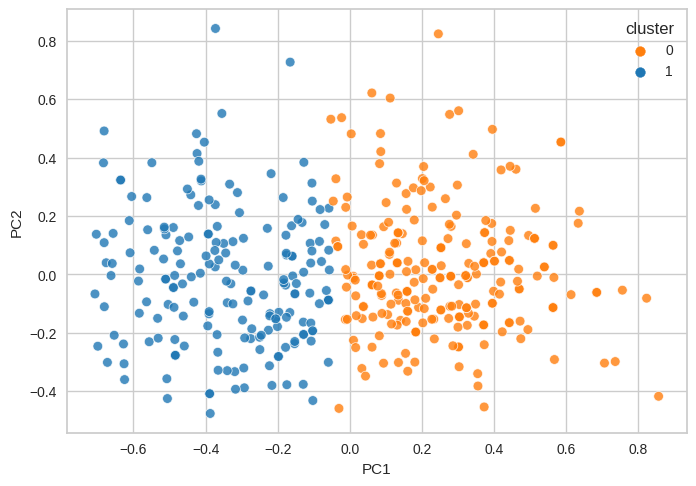

In [ ]:
# Creating K-means Cluster Model
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

seed = 1234 # Used for reproducibility

kmeans = KMeans(n_clusters=2, n_init = 10, random_state=seed)
k_fit = kmeans.fit(model)
centroids = kmeans.cluster_centers_
predictions = k_fit.labels_

# Develop 2 PCA components for visualizations
pca = PCA(2)
pca_data = pd.DataFrame(pca.fit_transform(model),columns=['PC1','PC2'])

# To maintain cluster colours to allow for easier comparison between cluster plots
color_dict = dict({0: sns.color_palette("tab10")[1], 1: sns.color_palette("tab10")[0]})

pca_data['cluster'] = pd.Categorical(predictions)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data, palette=color_dict, alpha=0.8)

In [ ]:
#pca_data.to_excel('pcaSC_work_v_clusters.xlsx', index=False) # to be used for comparison in personality notebook

#Latent Class Analysis

In [ ]:
from sklearn.model_selection import ParameterGrid
# Create LCA model
model = StepMix(n_components=3, measurement="categorical", verbose=1, random_state=123, n_init=10)

grid = {
    'n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    'n_steps' : [1]
}

results = dict(param_n_steps=[], param_n_components=[], aic=[], bic=[])


# Same model and grid as above
for g in ParameterGrid(grid):
    model.set_params(**g)
    model.fit(data_lca)
    results['param_n_steps'].append(g['n_steps'])
    results['param_n_components'].append(g['n_components'])
    results['aic'].append(model.aic(data_lca))
    results['bic'].append(model.bic(data_lca))

# Save results to a dataframe
results = pd.DataFrame(results)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 19.95it/s, max_LL=-741, max_avg_LL=-1.66]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 7 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.3645 0.6355 0.0000 0.0000 0.0000 0.8941 0.1059 0.0000 0.0000 0.0000
 0.5763 0.4237 0.0000 0.0000 0.0000 0.6822 0.3178 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.3645 0.6355 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.2925 0.1006 0.2344 0.1188 0.2537]
    Class weights
        Class 1 : 0.02
        Cl

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 26.89it/s, max_LL=-741, max_avg_LL=-1.66]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 7 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [0.3645 0.6355 0.0000 0.0000 0.0000 0.8941 0.1059 0.0000 0.0000 0.0000
 0.5763 0.4237 0.0000 0.0000 0.0000 0.6822 0.3178 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.3645 0.6355 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.2972 0.0982 0.2245 0.1226 0.2575]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.00

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 31.68it/s, max_LL=-741, max_avg_LL=-1.66]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 7 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.2929 0.1000 0.2546 0.1088 0.2437]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.2920 0.1055 0.2253 0.1208 0.2565]
        Class 3 : [0.3645 0.6355 0.0000 0.0000 0.00

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 34.02it/s, max_LL=-741, max_avg_LL=-1.66]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 7 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.2914 0.1048 0.2128 0.1293 0.2617]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.3297 0.1054 0.1805 0.1143 0.2701]
        Class 3 : [0.3645 0.6355 0.0000 0.0000 0.00

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 32.66it/s, max_LL=-741, max_avg_LL=-1.66]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 7 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.2893 0.1009 0.2350 0.1137 0.2611]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.2992 0.0933 0.2332 0.1270 0.2473]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.00

Initializations (n_init) : 100%|██████████| 10/10 [00:01<00:00,  7.91it/s, max_LL=-740, max_avg_LL=-1.66]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 7 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.3225 0.1025 0.1267 0.1428 0.3055]
        Class 2 : [0.2118 0.7882 0.0000 0.0000 0.0000 0.8686 0.1314 0.0000 0.0000 0.0000
 0.5923 0.4077 0.0000 0.0000 0.0000 0.6059 0.3941 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 0.2959 0.7041 0.0000 0.0000 0.0000
 0.0000 0.0000 1.0000 0.0000 0.0000]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.00

Initializations (n_init) : 100%|██████████| 10/10 [00:00<00:00, 38.76it/s, max_LL=-741, max_avg_LL=-1.66]


MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 7 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.2838 0.0963 0.2482 0.1253 0.2464]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.3024 0.0930 0.2038 0.1234 0.2774]
        Class 3 : [1.0000 0.0000 0.0000 0.0000 0.00

Initializations (n_init) : 100%|██████████| 10/10 [00:02<00:00,  4.52it/s, max_LL=-740, max_avg_LL=-1.66]

MODEL REPORT
    Measurement model parameters
        ------------------------------------------------------------------------
        Multinoulli model with 7 features, each with 5 possible outcomes
        ------------------------------------------------------------------------
        Columns 1 to 5 are associated with the first feature,
        columns 6 to 10 are associated with the second feature, etc.

        Class 1 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.3237 0.1132 0.1500 0.1321 0.2809]
        Class 2 : [1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 1.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000
 0.3112 0.1103 0.1266 0.1344 0.3176]
        Class 3 : [0.2121 0.7879 0.0000 0.0000 0.00

In [ ]:
results # print LCA results

,param_n_steps,param_n_components,aic,bic
0,1,2,1604.069568,1854.325643
1,1,3,1666.069568,2043.504959
2,1,4,1728.069568,2232.684275
3,1,5,1790.069568,2421.863592
4,1,6,1852.069568,2611.042908
5,1,7,1912.237398,2798.390055
6,1,8,1976.069568,2989.401541
7,1,9,2036.241685,3176.752974
